<a href="https://colab.research.google.com/github/mannixp/Plumes/blob/main/Stochastic_Plume_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We load the neccessary libraries, specifiy the domain $z \in [0,1]$ and the differentiation matrices $D = d/dz$ and $L = d^2/dz^2$.

In [7]:
from scipy.integrate   import solve_ivp
from scipy.ndimage     import gaussian_filter
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
#import numba as nb

ε    = 1e-12
π    = np.pi
Npts = 64

z = np.linspace(0+ε,1-ε,Npts)

I = np.eye(Npts) # I
D = np.zeros((Npts,Npts)) # D = d/dz
L = np.zeros((Npts,Npts)) # L = d2/dz2
for i,z_i in enumerate(z):

    if i == 0:
      #D
      D[i,i+1] =  1

      #L
      L[i,i  ] = -2
      L[i,i+1] =  2 # if db/dz = 0
    elif i == Npts-1:
      #D
      D[i,i-1] = -1

      # L
      L[i,i-1] =  2 # if db/dz = 0
      L[i,i  ] = -2
    else:
      # D
      D[i,i-1] = -1
      D[i,i+1] =  1

      # L
      L[i,i-1] =  1
      L[i,i  ] = -2
      L[i,i+1] =  1

dz = z[1] - z[0]
L /= dz**2
D /= 2*dz

From the plume equations
\begin{align*}
\frac{dF}{dz} &= -\frac{d b}{d z} Q, \\
\frac{dQ}{dz} &= \frac{Q}{z} + \frac{3^4}{2^6} \frac{\delta^4 \pi^2 z^4}{Q^2} F, \\
\end{align*}
where $F(z)$ and $Q(z)$ are the horizontally averaged (steady) buoyancy flux and volume flux respectively. This model contains two free parameters the Buoyancy frequency $N^2(z) = \frac{d b}{d z}$ which characterises the background vertical stratification and the dimensionless turbulence production coefficient $\delta < 0$. These equations are implemented below.

In [8]:
#@nb.njit()
def plume_eqns(z,X,z_i,dbdz_i,plume_type,δ=-0.25):

    """
    F,Q  = X
    """

    dX    = 0*X
    if plume_type == "Rise":
      dX[0] = -np.interp(z,z_i,dbdz_i)*X[1];
    elif plume_type == "Sink":
      dX[0] = -np.interp(1-z,z_i,dbdz_i)*X[1];

    dX[1] = X[1]/z + ((3**4)/(2**6))*( ((z**4)*(δ**4)*(π**2))/(X[1]**2) )*X[0]
    return dX;

To solve these equations we first set up an ode solver using scipy, which for a rising plume takes as initial conditions
\begin{align*}
Q(z=0) &= Q_0, \\
F(z=0) &= P_{F|Q}(f|q=Q_0,z=0) = \mathcal{N}(\mu=F_0,\sigma^2=0.1\mu)
\end{align*}
where the buoyancy flux is drawn from a normal distribution centered around $F_0$ with a variance that is 10% of the mean. The equations are then solved from $z=0 \to 1$ until $F=0$ at which point the integration is terminated. This corresponds to the plume attaining its neutrally buoyant height. For a descending plume we specifiy the above conditions at $z=1$ and integrate from $z=1 \to 0$ until $F=0$. \\

As $F(z=0,1)$ is given by a distribution, we make use of a Monte-Carlo approach in order to obtain the average solution. This consists of running whereby a large ensemble of initial conditions and then averaging over the ensemble of their solutions.

In [9]:
def Plot_F_and_Q(f,q,label_f='$F(z)$',label_q='$Q(z)$'):

  fig, (ax1, ax2) = plt.subplots(1, 2)

  ax1.plot(z[1:-1], f[1:-1], 'b')
  ax1.set_xlabel(r'$z$')
  ax1.set_ylabel(label_f)
  plt.grid()

  ax2.plot(z[1:-1], q[1:-1], 'r')
  ax2.set_xlabel(r'$z$')
  ax2.set_ylabel(label_q)
  plt.grid()

  plt.tight_layout()
  plt.show()

  return None;

def N(μ=0,σ=.1,samples = 10**2):

  """
  Generate N_samples from a Normal distribution

  N(μ,σ2)

  of mean μ and standard deviation σ.

  """

  return np.random.default_rng().normal(loc=μ,scale=σ,size=samples)

def Plume_Solve(F0,dbdz):

    def event(t,y,*args): return y[0];
    event.terminal = True;
    event.positive = 0

    if F0 < 0:
      plume_type = "Sink"
    elif F0 >0:
      plume_type = "Rise"

    # Solver
    sol  = solve_ivp(fun=plume_eqns,t_span=[z[0],z[-1]], y0=[abs(F0),ε], t_eval=z,args=(z,dbdz,plume_type),events=event)

    F = 0.*z;
    Q = 0.*z;
    if F0 > 0.:
      F[0:len(sol.y[0])] = sol.y[0]
      Q[0:len(sol.y[1])] = sol.y[1]
    elif F0 < 0.:
      F[Npts-len(sol.y[0]):] =     sol.y[0][::-1]
      Q[Npts-len(sol.y[1]):] = -1.*sol.y[1][::-1]

    return F,Q

def Plume_Solve_Monte_Carlo(F0,Nsq,samples = 10**2):

  # Get the samples
  std_dev = (abs(F0)/10.) # 10% of the mean
  μ       = F0
  F_0     = N(μ=μ,σ=std_dev,samples=samples)

  # print('Checking distribution mu,std_dev=',abs(μ - np.mean(F_0)),abs(std_dev - np.std(F_0) ))
  # plt.hist(F_0, bins=30, density=True)
  # plt.show()

  # Containers for the solution
  Q = 0*z
  F = 0*z

  for f_0 in F_0:
    Fi,Qi  = Plume_Solve(f_0,Nsq)
    F+=Fi; Q+=Qi

  F /=samples
  Q /=samples

  return F,Q

def Plume_Solve_Fokker_Planck(F0,Nsq,samples = 10**2):

  raise NotImplementedError

Generate rising and descending plumes using: 

(1) A deterministic approach with a fixed initial condition $F_i$

In [ ]:
# Initial conditions
Nsq    = 1*(z/z)
Plumes = {'F1':.1,'F2':-.1}

Q = 0*z
F = 0*z
for F_key,F_value in Plumes.items():

  print(F_key,F_value)
  Fi,Qi  = Plume_Solve(F_value,Nsq)
  Plot_F_and_Q(Fi,Qi)
  F+=Fi; Q+=Qi

Plot_F_and_Q(F,Q)

(2) A Monte-Carlo approach by sampling from a normal distribution of mean $F_i$ and standard deviation 10% of the mean.

In [ ]:
Q = 0*z
F = 0*z
for F_key,F_value in Plumes.items():

  print(F_key,F_value)
  Fi,Qi  = Plume_Solve_Monte_Carlo(F_value,Nsq,samples = 10**3)
  Plot_F_and_Q(Fi,Qi)
  F+=Fi; Q+=Qi

Plot_F_and_Q(F,Q)

(3) A solution of the Fokker-Planck equation
\begin{equation}
    \frac{\partial }{\partial z} P_{FQ} = -\frac{\partial }{\partial f} \left[ \left(-N^2(z) q \right) P_{FQ} \right] -\frac{\partial }{\partial q} \left[ \left( \frac{q}{z-z_v} + \frac{3^4}{2^6} \frac{\delta^4 \pi^2 (z - z_v)^4}{q^2} f \right) P_{FQ} \right] + D_F \frac{\partial^2 P_{FQ}}{\partial f^2} + D_Q \frac{\partial^2 P_{FQ}}{\partial q^2}.
\end{equation}
with the initial condition
\begin{equation}
    P_{F|Q}(f|q=0;z=0) = \mathcal{N}(\mu = F_i, \sigma^2 = 0.1\mu),
\end{equation}
where $z$ has been shifted to the virtual origin $z \to z - z_v$ where $z_v \leq 0$, in order to avoid the singularities which would otherwise occur at $z=0$.

To solve this equation we load the base class **FD_Solve** which includes routines to solve the Fokker-Planck equation using a finite difference method.

In [245]:
from Finite_Difference_Solver import FD_Solve

Inherting this class we then write a class specific to our equation which includes the diffusion and drift terms as implemented below.

In [247]:
class PlumesFokkerPlanck(FD_Solve):

    """
    Solver class derived from FD solve which solves the Foker-planck equation underlying the plume equations forced by a Wiener process

    Inputs
    -N grid-size (int)
    -domain (dictionary) e.g.  {'name':'x','interval':(-1,1)}

    Methods:
    -init
    -Lin_operator
    -NLin_operator
    -Histogram
    """

    def __init__(self,Nsq,z, N,domain,dt=0.01,endTime=10.):
      
      # Initialise the base clas
      super().__init__(N,domain,dt,endTime)

      # Set the system parameters
      self.δ   =-0.25
      self.z_v =-1e-03
      self.D_F = 0.0
      self.D_Q = 0.5

      # Stratification
      self.Nsq = Nsq
      self.z   = z

      # build the drift & Diffusion terms
      self.Drift_μ()

      # Probability Field
      self.P = 0
        
    def Drift_μ(self):
      
      # Create the nonlinear part
      II = sparse.eye(self.N);
      D  = self.Grad();
      self.Df = pow(self.df,-1)*sparse.kron( D, II);
      self.Dq = pow(self.dq,-1)*sparse.kron( II, D);

      # (2) Create flat arrays of each of these vectors using Kronecker product
      I = np.ones(self.N)
      f = np.kron(self.f,I)
      q = np.kron(I,self.q)

      # (3) Create the vector field
      self.F = lambda z: -np.interp(z,self.z,self.Nsq)*q;
      self.Q = lambda z: q/(z - self.z_v) + (3**4/2**6)*( ( (z-self.z_v)**4 * self.δ**4 * π**2)/(q**2) )*f

      return None

    def Lin_operator(self):

      """
      Build the lineat diffusion term

      L = - [ D_F ∂^2P/∂f^2 + D_Q ∂^2P/∂q^2 ]

      """

      # (1) Create a 2D mass matrix by using the kronecker product
      II     = sparse.eye(self.N);
      Lap_ff = self.D_F*pow(self.df,-2)*sparse.kron(self.Laplacian(bcs='Dirichlet'),II)
      Lap_qq = self.D_Q*pow(self.dq,-2)*sparse.kron(II,self.Laplacian(bcs='Neumann')  )

      return -sparse.csr_matrix(Lap_ff + Lap_qq)

    def NLin_operator(self,P,z):

      """
      Build the nonlinear drift term

      F(P,z) = −∂/∂f[(−N^2(z)q)*P]−∂/∂q[(q/z + (3^4/2^6)*(δ^4 π^2 z^4)/(q^2) f)*P]

      """

      return -self.Df@(self.F(z)*P) - self.Dq@(self.Q(z)*P)

    def Histogram(self):

        P = self.P;
        N = self.N;

        # Add plotting here
        # P is structured as ~ (X kron Y) kron Z
        # Reconstruct this as a 3D matrix
        W    = P.reshape( (N,N) );
        X, Y = np.meshgrid(self.f, self.q)

        fig = plt.figure()        

        ax = fig.add_subplot(111)
        cf = ax.pcolormesh(X,Y,W.T,cmap='Greys',vmax=np.max(W)) # Normalise this + show the colour bar ,norm="log"
        
        #ax = fig.add_subplot(111, projection='3d')
        #cf = ax.plot_surface(X, Y, W.T, cmap='Greys',linewidth=0, antialiased=False)
        
        ax.set_xlabel(r'buoyancy flux - $f$')
        ax.set_ylabel(r'volume flux - $q$')
        fig.colorbar(cf)
        plt.show()

        return None
    
    def Fluxes(self):
      
      fig = plt.figure()        
      ax1 = fig.add_subplot(121)
      ax2 = fig.add_subplot(122)

      P_FQ = self.P.reshape( (self.N,self.N) )
      I    = np.ones(self.N)

      f    = np.outer(self.f,I)
      EF_Z = np.trapz(y = f*P_FQ,x = self.q,axis=1)

      ax1.plot(self.f, EF_Z)
      ax1.set_xlabel(r'$f$')
      ax1.set_ylabel(r'$P_F(f)$')

      q     = np.outer(I,self.q)
      EQ_Z = np.trapz(y = q*P_FQ,x = self.f,axis=0)

      ax2.plot(self.q, EQ_Z)
      ax2.set_xlabel(r'$q$')
      ax2.set_ylabel(r'$P_Q(q)$')
    
      plt.tight_layout()
      plt.show()
      
      return None

We first obtain solutions for rising plumes. 

To do so we restrict the domain to be semi-infinite $\Omega_{FQ}: \mathbb{R}^+ \times \mathbb{R}$ (in practice a domain of finite size) and impose the absorb boundary conditions
\begin{equation}
    P_{FQ}(f=0,q;z) = P_{FQ}(f=1,q;z) = 0,
\end{equation}
for $F$. While for $Q$ we have the boundary conditions **???**
\begin{equation}
    P_{FQ}(f,q=\pm 1;z) = 
\end{equation}
For the initial distribution we specify a product of the normal distribution times the gamma distribution
\begin{equation}
    P_{FQ}(f,q;z=0) = \mathcal{N}(\mu = F_i, \sigma^2 = 0.1\mu) \Bigl( \frac{\beta^{\alpha}}{\Gamma(\alpha)} x^{\alpha -1} e^{-\beta x} \Bigr)
\end{equation}
such that there is zero probability of events with $Q=0$. 

Initial mass = 0.9999793932879496


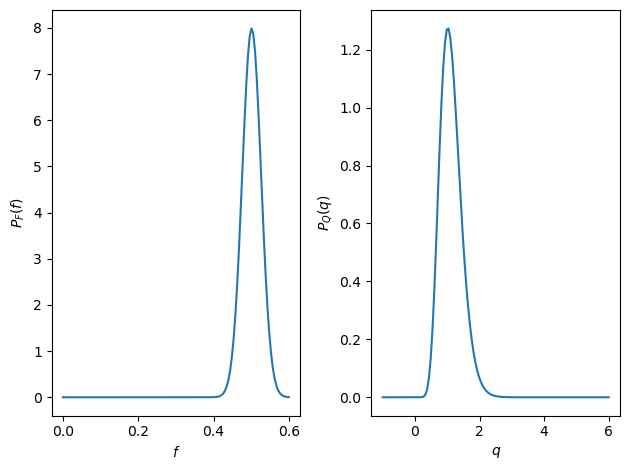

Elapsed time (s) = 1.030113e+00
Conserved mass: int_v P dv = 0.996253042711539


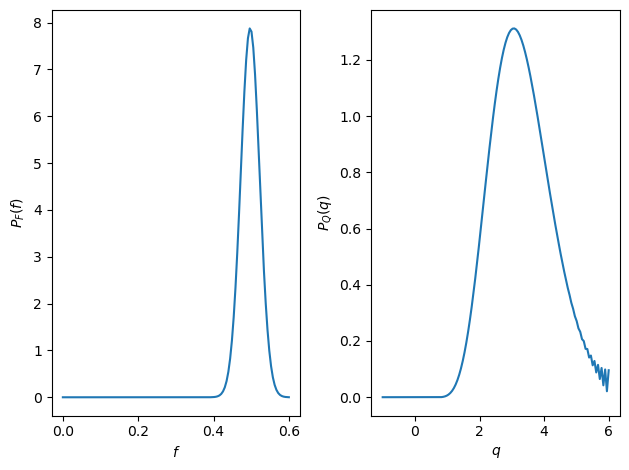

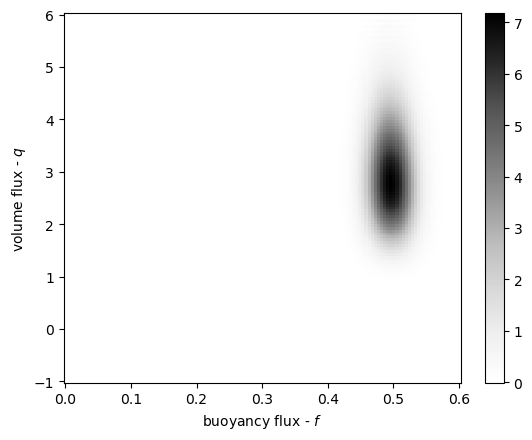

In [261]:
# Domain
Ω_FQ = [ {'name':'f','interval':(0,.6)}, {'name':'q','interval':(-1,6)} ]

Nsq    = 1*np.exp(z) #(z/z)

# Boundary conditions

# Solver
FP   = PlumesFokkerPlanck(Nsq,z,N=128,domain=Ω_FQ,dt=1e-05,endTime=2e-3)

# Initial distribution
F_i = 0.5
from scipy.stats import gamma,norm
P_F  = norm.pdf(FP.f,loc=F_i,scale=0.05*F_i)
P_Q  = gamma.pdf(FP.q,a=10,loc=0.02,scale=0.1)
FP.P = np.kron(P_F,P_Q)
print('Initial mass =',np.sum(FP.P*FP.dV))

#FP.Histogram()
FP.Fluxes()
FP.Time_Integrate(θ = 0.5)
FP.Fluxes()
FP.Histogram()

In [ ]:
Q = 0*z
F = 0*z
for F_key,F_value in Plumes.items():

  print(F_key,F_value)
  Fi,Qi  = Plume_Solve_Fokker_Planck(F_value,Nsq,samples = 10**3)
  Plot_F_and_Q(Fi,Qi)
  F+=Fi; Q+=Qi

Plot_F_and_Q(F,Q)

Equipped with a means to obtain the velocity field we can now combine this with the 1D advection diffusion equation for buoyancy
\begin{equation*}
\frac{\partial b}{\partial t} + \bar{w} \frac{\partial b}{\partial z} = \frac{\partial }{\partial z} \Big( \Gamma \frac{\partial b}{\partial z} \Big),
\end{equation*}
where
\begin{equation*}
\bar{w}(z) = -\frac{1}{A} \sum_i Q_i(z),
\end{equation*}
and $\Gamma$ is a turbulent diffusion. To do we solve the advection diffusion equation for buoyancy $b(z,t)$ as below, where $\Gamma$ is taken as a constant.

In [ ]:
def step_buoyancy(w,b,Γ=.1,Δt=1e-03,A_inv = None, B = None):

    """
    Step forward using one time-step

    if Γ > 0:
    Crank-Nicolson
    elif Γ == 0
    Euler-Explicit

    returns b(z,t_n+1)
    """

    if Γ > 0:

      if (A_inv is None) and (B is None):
        A = (I/Δt - .5*Γ*L)
        B = (I/Δt + .5*Γ*L)
        return np.linalg.solve(A,B@b - w*(D@b) )
      else:
        return A_inv@( B@b - w*(D@b) )

    elif Γ == 0:

      #Courant number |c*dt/dx| < 1
      c = np.max(abs(w))
      while  (c*Δt)/dz > 1.:
        dt *=0.5

      return b - Δt*w*(D@b)

With a solver developed for the plume equations and for the 1D buoyancy equations we now link these routines together to establish the background stratification profile for a given set of plume sources and sinks. We consider the case of two opposing plumes of equal strength. \\

We first specify initial conditions for the rising plume
\begin{align}
  F_1(z=0) &= .1, \\
  Q_1(z=0) &= 0, \\
\end{align}
the sinking plume
\begin{align}
  F_2(z=1) &=-.1, \\
  Q_2(z=1) &= 0, \\
\end{align}
and the initial stratification
\begin{equation}
  db/dz(z,t_0=0) = 1.
\end{equation}
Using these boundary conditions we then:
- Solve the plume equations using $db/dz(z,t_n)$ for each of the plumes to obtain $Q_i^n$
- Compute $\bar{w}(z,t_n)$ from the sum of the plumes's volume fluxes $Q_i^n$
- Timestep the 1D buoyancy equation forward from $t_n \to t_n + \Delta t$ to update $db/dz(z,t_n)$ \\

This process is repeated until the residual error
\begin{equation}
  || db^{n+1}/dz - db^{n}/dz ||_2/||db^{n}/dz || < \text{tol},
\end{equation}
falls below a user prescribed tolerance.

In [ ]:
def Strat_solve(b,Plumes,Γ=1e-02,Δt=1e-03,Area=1.0,Iterations=10**4,method=None):

  A_inv = np.linalg.inv(I/Δt - .5*Γ*L)
  B     = (I/Δt + .5*Γ*L)

  Error = [1.0];
  iter  = 0;
  Nsq   = D@b;

  while (iter < Iterations):

    # (1) solve plume equations
    w = 0*z
    for F_key,F_value in Plumes.items():

      if method =='Monte_Carlo':
        Q_i= Plume_Solve_Monte_Carlo(F_value,Nsq,samples = 100)[1]
      elif method =='Fokker_Planck':
        Q_i= Plume_Solve_Fokker_Planck(F_value,Nsq,samples = 10)[1]
      else:
        Q_i= Plume_Solve(F_value,Nsq)[1]

      w -= Q_i/Area

    # (2) step db/dt forward
    b = step_buoyancy(w,b,Γ=Γ,Δt=Δt,A_inv=A_inv,B=B)

    # (3) update N^2 & check converged
    Error.append(  np.linalg.norm(Nsq - D@b,2)/np.linalg.norm(Nsq,2) )
    Nsq   = D@b;
    iter += 1.

    if iter%(Iterations//10) ==0:
      print('Iteration i = %d, Residual error r_i = %e \n'%(iter,Error[-1]))
      Plot_F_and_Q(w,b,label_f='w(z)',label_q='b(z)')

  return Error,w,b;

In [ ]:
# Sources and IC
b      = 1*z;
Plumes = {'F1':.1,'F2':-.1}

# Solve
Error,w,b = Strat_solve(b,Plumes,Iterations=10**3,method='Monte_Carlo')

plt.ylabel(r'$|N^2_{i+1} - N^2_i|_2/|N^2_i|_2$')
plt.xlabel(r'Iteration $i$')
plt.semilogy(Error)
plt.show()

Plot_F_and_Q(w  ,b  ,label_f='w(z)'    ,label_q='b(z)'  )
Plot_F_and_Q(D@w,D@b,label_f='dw(z)/dz',label_q='N^2(z)')